In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
import os
import numpy as np

from common import h5dataset, onnxexporter, model_dnn


In [2]:
class ModelDNNDisc(nn.Module):
    def __init__(self, name: str, input_size : int, embedding_size :int, hidden_size :list, output_size :int, embedding_num :int = 37):
        super(ModelDNNDisc, self).__init__()
        self.name = name + "_" + "_".join(map(str, hidden_size)) + "_dnn"
        self.embedding = nn.Embedding(embedding_num, embedding_size)
        self.flat = nn.Flatten()
        dim_in = input_size * embedding_size + 9
        layers = []
        for h in hidden_size:
            layers.append(nn.Linear(dim_in, h))
            layers.append(nn.ReLU())
            dim_in = h
        layers.append(nn.Linear(dim_in, output_size))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, state, action) -> torch.Tensor:
        x = self.forward_embedded(state)
        action = F.one_hot(action, num_classes=9).float()
        x = self.forward_layers(torch.cat((x, action), dim=1))
        return x
    
    def forward_embedded(self, x) -> torch.Tensor:
        x = self.embedding(x)
        x = self.flat(x)
        return x
    
    def forward_layers(self, x) -> torch.Tensor:
        x = self.layers(x)
        return x

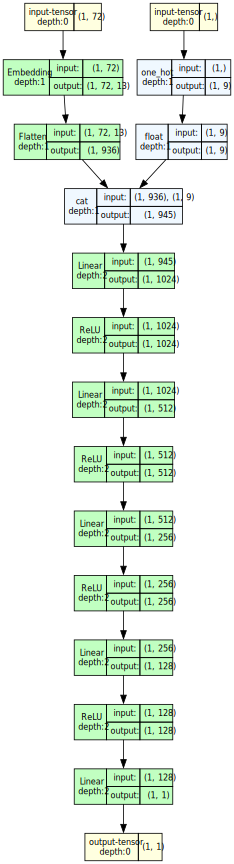

In [3]:
# Plot model graph
model = ModelDNNDisc(
    name="Jass",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=1,
)
model_graph = draw_graph(model, (torch.zeros(1, 72).long(), torch.zeros(1).long()), show_shapes=True)
model_graph.visual_graph

In [17]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/disc'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/disc'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

SL_MODEL_PATH = './models/play/JassPlay_512_256_128_dnn.pth'
if not os.path.exists(SL_MODEL_PATH):
    raise FileNotFoundError(f"Supervised learning model not found at {SL_MODEL_PATH}")

WGAN_PRETRAINED_PATH = './models/play_gan_pretrained/JassGanGen_1024_512_256_128_dnn.pth'
if not os.path.exists(WGAN_PRETRAINED_PATH):
    raise FileNotFoundError(f"WGAN pre-trained model not found at {WGAN_PRETRAINED_PATH}")

WGAN_PATH = './models/play_gan/JassGanGen_512_256_128_dnn.pth'
if not os.path.exists(WGAN_PATH):
    raise FileNotFoundError(f"WGAN model not found at {WGAN_PATH}")


In [18]:
model_sl  = model_dnn.ModelDNN("Jass", 72, 13, [512,256,128], 9)
model_sl.load_state_dict(torch.load(SL_MODEL_PATH, map_location="cpu")); model_sl.eval()
model_gan_pre = model_dnn.ModelDNN("JassGanPre", 72, 13, [1024,512,256,128], 9)
model_gan_pre.load_state_dict(torch.load(WGAN_PRETRAINED_PATH, map_location="cpu")); model_gan_pre.eval()
model_gan = model_dnn.ModelDNN("JassGan", 72, 13, [512,256,128], 9)
model_gan.load_state_dict(torch.load(WGAN_PATH, map_location="cpu")); model_gan.eval()


@torch.no_grad()
def random_policy(states_cpu: torch.Tensor, n_choice=0) -> torch.Tensor:
    if states_cpu.dim() == 1:
        return torch.randint(0, 9, (1,), dtype=torch.long)
    B = states_cpu.size(0)
    return torch.randint(0, 9, (B,), dtype=torch.long)


@torch.no_grad()
def sl_policy(states_cpu: torch.Tensor, n_choice=0) -> torch.Tensor:
    if states_cpu.dim() == 1:
        logits = model_sl(states_cpu.unsqueeze(0))
    else:
        logits = model_sl(states_cpu)
    # Get the top k predictions and select the nth one
    _, topk_idx = torch.topk(logits, k=min(9, n_choice+1), dim=1)
    return topk_idx[:, n_choice].long()


@torch.no_grad()
def gan_policy(states_cpu: torch.Tensor, n_choice=0) -> torch.Tensor:
    if states_cpu.dim() == 1:
        logits = model_gan(states_cpu.unsqueeze(0))
    else:
        logits = model_gan(states_cpu)
    _, topk_idx = torch.topk(logits, k=min(9, n_choice+1), dim=1)
    return topk_idx[:, n_choice].long()


FAKE_GENS = [random_policy, sl_policy, gan_policy]
GEN_PROBS  = torch.tensor([1/3, 1/3, 1/3])  # mix per sample


In [6]:
from torch.utils.data import DataLoader
from common.training_monitor import TrainingMonitor
from signal import signal, getsignal, SIGINT, SIGTERM
from tqdm import tqdm
from common.model_dnn import ModelDNN

class Trainer:
    def __init__(self, loss_fn, accuracy_fn, train_loader, val_loader, model_path, device='cpu',
                 fake_gens=None, gen_probs=None, val_gen_id=1, fake_ratio=1.0):
        self.model_path = model_path
        self.loss_fn = loss_fn
        self.accuracy_fn = accuracy_fn
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.stop_training = False
        self.device = device
        self.monitor = TrainingMonitor()
        self.fake_gens = fake_gens or []
        self.original_sigint_handler = getsignal(SIGINT)
        self.gen_probs = (gen_probs / gen_probs.sum()) if gen_probs is not None else None
        self.val_gen_id = val_gen_id  # use a fixed gen at val for stable metric
        self.fake_ratio = fake_ratio  # 1.0 = 50/50 (|fake| == |real|)

    def _signal_handler(self, signum, frame):
        print(f"Received signal {signum}, stopping training...")
        signal(SIGINT, self.original_sigint_handler)
        self.stop_training = True

    def train(self, epochs: int, model: ModelDNN, optimizer=None):
        signal(SIGINT, self._signal_handler)
        print(f"Training model: {model.name}")
        for epoch in range(epochs):
            train_loss, train_accuracy = self._train_epoch(epoch, model, optimizer)
            val_loss, val_accuracy = self._validate_epoch(epoch, model)
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            
            if val_loss < min(self.monitor.epoch_data_validation["loss"][model.name][:-1], default=float('inf')):
                torch.save(model.state_dict(), self.model_path + f"/{model.name}.pth")
                print(f"Model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")
            elif [val_loss <= v for v in self.monitor.epoch_data_validation["loss"][model.name][:-1]].count(False) > 2:
                break

            if self.stop_training:
                print("Early stopping triggered.")
                break
        # Restore the original signal handler
        signal(SIGINT, self.original_sigint_handler)

    def _make_fake_actions(self, states, gid=None):
        """
        states: [B,72] tensor (any device)
        returns: [B] long tensor of actions, computed by a single generator for the whole batch.
        """
        # policies run on CPU in your setup
        states_cpu = states.detach().cpu()

        # choose one generator for this batch if not provided
        if gid is None:
            if self.gen_probs is None:
                probs = np.full(len(self.fake_gens), 1.0/len(self.fake_gens))
            else:
                probs = self.gen_probs.cpu().numpy()
            gid = int(np.random.choice(len(self.fake_gens), p=probs))

        acts = self.fake_gens[gid](states_cpu)   # batched: [B]
        return torch.as_tensor(acts, dtype=torch.long)  # [B]


    def _train_epoch(self, epoch, model, optimizer):
        model.train()
        tot_loss = 0.0; tot_acc = 0.0
        for states_real, actions_real in tqdm(self.train_loader, desc=f"Train {epoch+1}"):
            states_real = states_real.to(self.device, non_blocking=True)
            actions_real = actions_real.long().to(self.device, non_blocking=True)
            
            # how many fakes to make
            k = int(round(self.fake_ratio * states_real.size(0)))
            if k > 0:
                idx = torch.randint(0, states_real.size(0), (k,), device=states_real.device)
                states_fake_src = states_real.index_select(0, idx)
                human_fake_tgt   = actions_real.index_select(0, idx).view(-1)

                # choose ONE generator for this fake mini-batch
                if self.gen_probs is None:
                    probs = np.full(len(self.fake_gens), 1.0/len(self.fake_gens))
                else:
                    probs = self.gen_probs.cpu().numpy()
                batch_gid = int(np.random.choice(len(self.fake_gens), p=probs))

                actions_real = actions_real.long().view(-1)
                fake_actions = self._make_fake_actions(states_fake_src, gid=batch_gid).to(self.device).view(-1)

                same = (fake_actions == human_fake_tgt)
                if same.any():
                    # simplest: resample random actions until different
                    need = same.sum().item()
                    repl = torch.randint(0, 9, (need,), device=self.device, dtype=torch.long)
                    # enforce repl != human
                    while True:
                        mask = repl == human_fake_tgt[same]
                        if not mask.any(): break
                        repl[mask] = torch.randint(0, 9, (int(mask.sum().item()),), device=self.device, dtype=torch.long)
                    fake_actions[same] = repl

                states_all  = torch.cat([states_real, states_fake_src], 0)
                actions_all = torch.cat([actions_real, fake_actions], 0)
                labels_all  = torch.cat([
                    torch.ones(states_real.size(0), dtype=torch.long, device=self.device),
                    torch.zeros(k,               dtype=torch.long, device=self.device)
                ], 0)
            else:
                states_all, actions_all = states_real, actions_real
                labels_all = torch.ones(states_real.size(0), dtype=torch.long, device=self.device)

            optimizer.zero_grad()
            logits = model(states_all, actions_all)              # [B_total, 1]
            loss = self.loss_fn(logits, labels_all)              # BCEWithLogits on labels {0,1}
            loss.backward()
            optimizer.step()

            acc = self.accuracy_fn(logits, labels_all)
            tot_loss += loss.item()
            tot_acc  += acc.item()
            self.monitor.on_train_batch_end(model_name=model.name, key='loss', value=loss.item())
            self.monitor.on_train_batch_end(model_name=model.name, key='accuracy', value=acc.item()*100, unit="percent")

        n = len(self.train_loader)
        self.monitor.on_train_epoch_end(model_name=model.name, key='loss', value=tot_loss/n)
        self.monitor.on_train_epoch_end(model_name=model.name, key='accuracy', value=(tot_acc/n)*100, unit="percent")
        return tot_loss/n, (tot_acc/n)*100

    @torch.no_grad()
    def _validate_epoch(self, epoch, model):
        model.eval()
        tot_loss = 0.0; tot_acc = 0.0
        for states_real, actions_real in tqdm(self.val_loader, desc=f"Val {epoch+1}"):
            states_real = states_real.to(self.device, non_blocking=True)
            actions_real = actions_real.long().to(self.device, non_blocking=True)

            k = int(round(self.fake_ratio * states_real.size(0)))
            if k > 0:
                idx = torch.randint(0, states_real.size(0), (k,), device=states_real.device)
                states_fake_src = states_real.index_select(0, idx)
                human_fake_tgt   = actions_real.index_select(0, idx).view(-1)

                # choose ONE generator for this fake mini-batch
                if self.gen_probs is None:
                    probs = np.full(len(self.fake_gens), 1.0/len(self.fake_gens))
                else:
                    probs = self.gen_probs.cpu().numpy()
                batch_gid = int(np.random.choice(len(self.fake_gens), p=probs))

                actions_real = actions_real.long().view(-1)
                fake_actions = self._make_fake_actions(states_fake_src, gid=batch_gid).to(self.device).view(-1)

                same = (fake_actions == human_fake_tgt)
                if same.any():
                    # simplest: resample random actions until different
                    need = same.sum().item()
                    repl = torch.randint(0, 9, (need,), device=self.device, dtype=torch.long)
                    # enforce repl != human
                    while True:
                        mask = repl == human_fake_tgt[same]
                        if not mask.any(): break
                        repl[mask] = torch.randint(0, 9, (int(mask.sum().item()),), device=self.device, dtype=torch.long)
                    fake_actions[same] = repl

                states_all  = torch.cat([states_real, states_fake_src], 0)
                actions_all = torch.cat([actions_real, fake_actions], 0)
                labels_all  = torch.cat([
                    torch.ones(states_real.size(0), dtype=torch.long, device=self.device),
                    torch.zeros(k,               dtype=torch.long, device=self.device)
                ], 0)
            else:
                states_all, actions_all = states_real, actions_real
                labels_all = torch.ones(states_real.size(0), dtype=torch.long, device=self.device)

            states_all  = torch.cat([states_real, states_real], 0)
            actions_all = torch.cat([actions_real, fake_actions], 0)
            labels_all  = torch.cat([torch.ones(k, dtype=torch.long, device=self.device),
                                     torch.zeros(k, dtype=torch.long, device=self.device)], 0)

            logits = model(states_all, actions_all)
            loss = self.loss_fn(logits, labels_all)
            acc  = self.accuracy_fn(logits, labels_all)

            tot_loss += loss.item(); tot_acc += acc.item()

        n = len(self.val_loader)
        self.monitor.on_val_epoch_end(model_name=model.name, key='loss', value=tot_loss/n)
        self.monitor.on_val_epoch_end(model_name=model.name, key='accuracy', value=(tot_acc/n)*100, unit="percent")
        return tot_loss/n, (tot_acc/n)*100


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)

def disc_collate(batch):
    # batch: list of (state, action, label, gen_id)
    states, actions, labels, _ = zip(*batch)
    states  = torch.stack(states, 0)                     # [B,72]
    actions = torch.stack([a.long().view(()) for a in actions], 0)  # [B]
    labels  = torch.stack([l.long().view(()) for l in labels], 0)   # [B]
    return states, actions, labels

# Load dataset
dataset = h5dataset.H5Dataset(path=DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

accuracy_fn = lambda y_pred, y_true: (((torch.sigmoid(y_pred.squeeze(-1))) > 0.5).long() == y_true.long()).float().mean()
loss_fn = lambda y_pred, y_true: torch.nn.BCEWithLogitsLoss()(y_pred.squeeze(-1), y_true.float())
# set up trainer
trainer = Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    fake_gens=FAKE_GENS,
    gen_probs=GEN_PROBS,
    val_gen_id=1,  # use the first generator for validation
    fake_ratio=1.0,  # 50/50 real/fake ratio
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [8]:
# train the model
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer.train(NUM_EPOCHS, model, optimizer)

Training model: Jass_1024_512_256_128_dnn


Val 1: 100%|██████████| 17326/17326 [01:19<00:00, 217.30it/s]


Epoch 1/20 - Train Loss: 0.3402, Train Accuracy: 82.3478, Val Loss: 0.6403, Val Accuracy: 84.9713
Model saved at epoch 1 with validation loss 0.6403


Val 2: 100%|██████████| 17326/17326 [01:19<00:00, 218.96it/s]


Epoch 2/20 - Train Loss: 0.3095, Train Accuracy: 84.3569, Val Loss: 0.9699, Val Accuracy: 85.8215


Val 3: 100%|██████████| 17326/17326 [01:19<00:00, 218.56it/s]


Epoch 3/20 - Train Loss: 0.2986, Train Accuracy: 85.0949, Val Loss: 1.1960, Val Accuracy: 86.2918


Val 4: 100%|██████████| 17326/17326 [01:19<00:00, 217.30it/s]


Epoch 4/20 - Train Loss: 0.2906, Train Accuracy: 85.6215, Val Loss: 1.1517, Val Accuracy: 86.6181


Val 5: 100%|██████████| 17326/17326 [01:20<00:00, 215.48it/s]


Epoch 5/20 - Train Loss: 0.2857, Train Accuracy: 85.9492, Val Loss: 0.9874, Val Accuracy: 86.6808


Val 6: 100%|██████████| 17326/17326 [01:18<00:00, 220.61it/s]

Epoch 6/20 - Train Loss: 0.2822, Train Accuracy: 86.1772, Val Loss: 1.3458, Val Accuracy: 86.8191


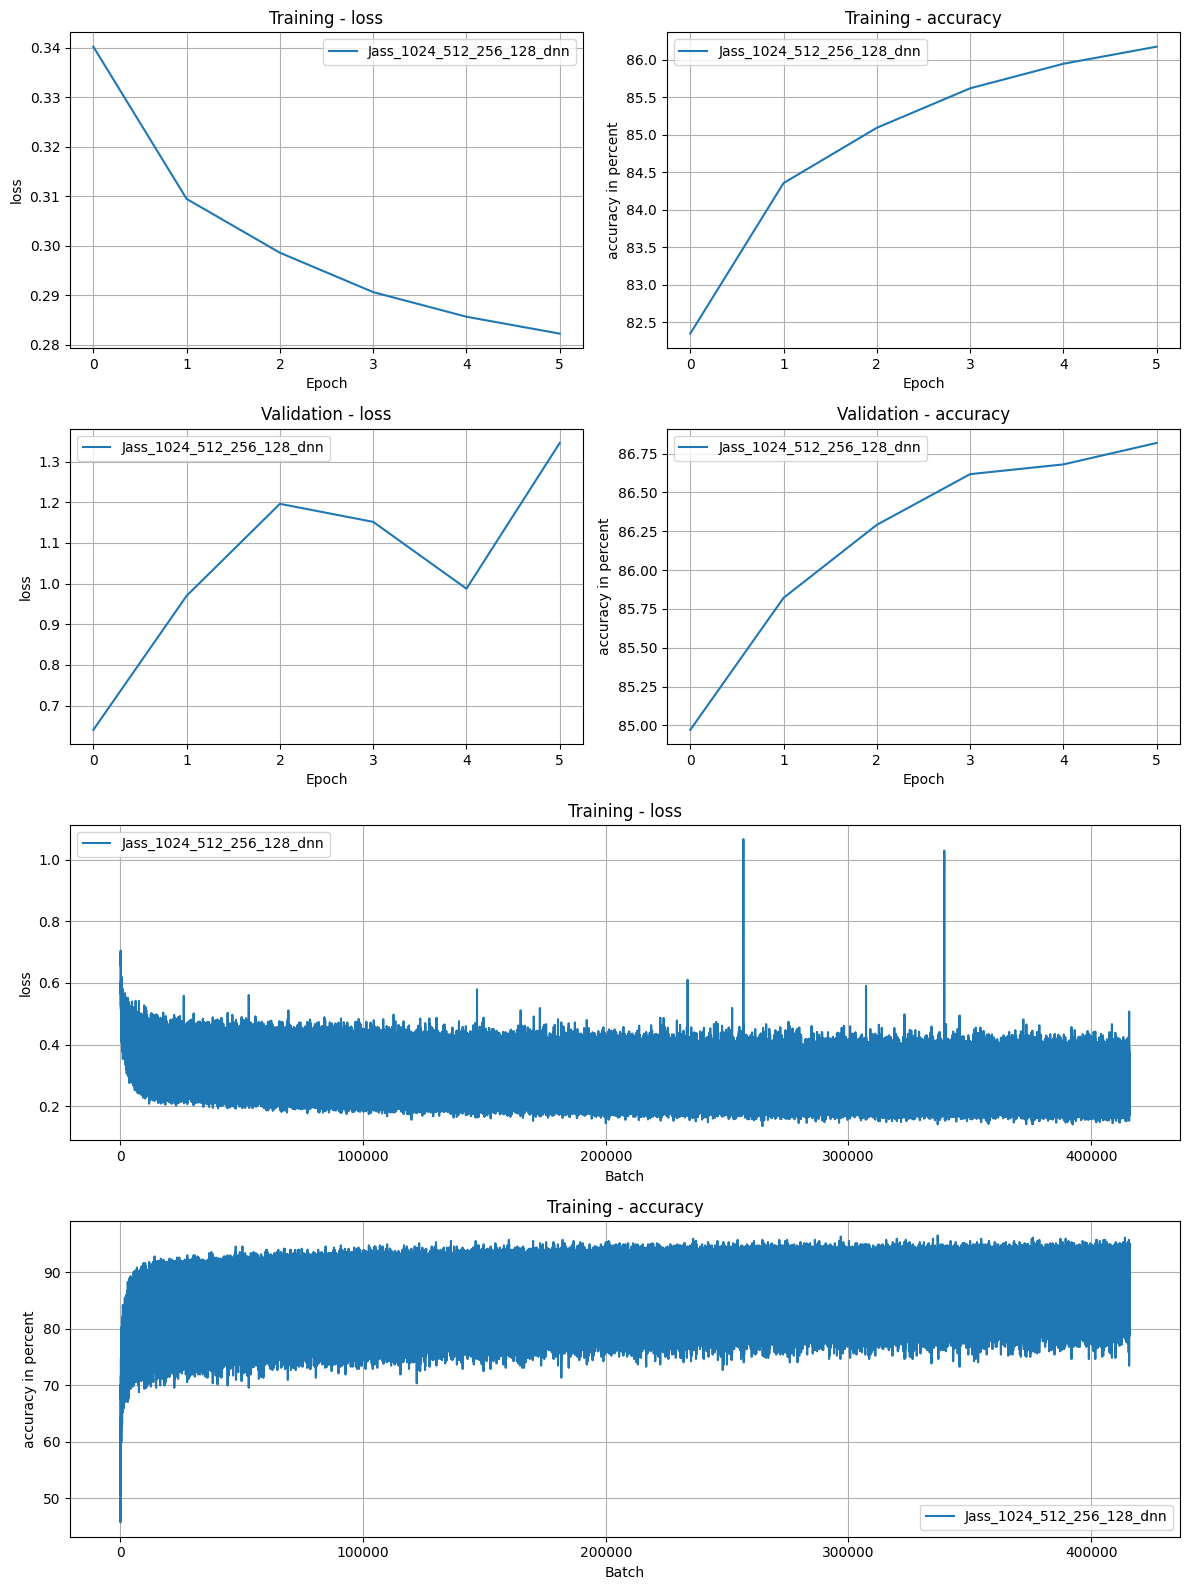

In [9]:
# create graphs
trainer.monitor.plot()

In [10]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [19]:
import pandas as pd

model.eval()

@torch.no_grad()
def ranked_choice_policy(base_model, states_cpu: torch.Tensor, n_choice: int) -> torch.Tensor:
    """Select the n_choice-th ranked action from the model's logits."""
    if states_cpu.dim() == 1:
        states_cpu = states_cpu.unsqueeze(0)  # [1,72]
    logits = base_model(states_cpu)  # [B,9]
    ranked = torch.argsort(logits, dim=1, descending=True)  # [B,9]
    return ranked[:, n_choice]  # [B]

@torch.no_grad()
def score_policy(policy_name, policy_fn, device=device, max_batches=None):
    """Returns P(real|s,a) scores and exact match rate."""
    probs = []
    matches, total = 0, 0
    for i, (states, human_actions) in enumerate(tqdm(val_loader, desc=f"Scoring {policy_name}")):
        if max_batches is not None and i >= max_batches:
            break
        states = states.to(device, non_blocking=True)
        human_actions = human_actions.to(device, non_blocking=True).long().view(-1)

        if policy_fn is None:
            actions = human_actions
        else:
            actions = policy_fn(states.cpu()).to(device).long().view(-1)

        logits = model(states, actions).squeeze(-1)  # [B]
        probs.append(torch.sigmoid(logits).detach().cpu())

        matches += (actions == human_actions).sum().item()
        total += human_actions.numel()

    if not probs:
        return np.array([], dtype=np.float32), 0.0
    return torch.cat(probs, 0).numpy(), matches / total

def bootstrap_ci(x, n_boot=1000, alpha=0.05, seed=123):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return (np.nan, np.nan, np.nan)
    means = []
    n = x.size
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        means.append(x[idx].mean())
    lo, hi = np.quantile(means, [alpha/2, 1-alpha/2])
    return (x.mean(), lo, hi)

# Define base policies
base_policies = {
    "Human (dataset)": None,
    "Random": lambda s: torch.randint(0, 9, (s.size(0),), dtype=torch.long),
    "SL": lambda s: ranked_choice_policy(model_sl, s, 0),
    "GAN": lambda s: ranked_choice_policy(model_gan, s, 0),
}

rows = []
MAX_VAL_BATCHES = None

# Human once
p, exact = score_policy("Human (dataset)", None, max_batches=MAX_VAL_BATCHES)
mu, lo, hi = bootstrap_ci(p)
rows.append({
    "policy": "Human (dataset)",
    "choice_rank": 1,
    "n_samples": int(p.size),
    "mean_P(real)": float(mu),
    "CI95_low": float(lo),
    "CI95_high": float(hi),
    "exact_match_rate": f"{exact*100:.2f}%"
})

# Random once
p, exact = score_policy("Random", base_policies["Random"], max_batches=MAX_VAL_BATCHES)
mu, lo, hi = bootstrap_ci(p)
rows.append({
    "policy": "Random",
    "choice_rank": 1,
    "n_samples": int(p.size),
    "mean_P(real)": float(mu),
    "CI95_low": float(lo),
    "CI95_high": float(hi),
    "exact_match_rate": f"{exact*100:.2f}%"
})

# SL & GAN for choice_rank = 1..3
for name, model_fn in [("SL", model_sl), ("GAN", model_gan), ("GAN-pretrained", model_gan_pre)]:
    for choice_rank in [0, 1, 2]:
        fn = lambda s, m=model_fn, c=choice_rank: ranked_choice_policy(m, s, c)
        p, exact = score_policy(f"{name}-top{choice_rank+1}", fn, max_batches=MAX_VAL_BATCHES)
        mu, lo, hi = bootstrap_ci(p)
        rows.append({
            "policy": name,
            "choice_rank": choice_rank+1,
            "n_samples": int(p.size),
            "mean_P(real)": float(mu),
            "CI95_low": float(lo),
            "CI95_high": float(hi),
            "exact_match_rate": f"{exact*100:.2f}%"
        })

df_rank = pd.DataFrame(rows).sort_values(
    ["policy", "choice_rank"], ascending=[True, True]
).reset_index(drop=True)

display(df_rank.style.format({
    "mean_P(real)": "{:.4f}",
    "CI95_low": "{:.4f}",
    "CI95_high": "{:.4f}"
}))





Scoring GAN-pretrained-top3: 100%|██████████| 17326/17326 [01:17<00:00, 224.32it/s]


,policy,choice_rank,n_samples,mean_P(real),CI95_low,CI95_high,exact_match_rate
0,GAN,1,4435426,0.7724,0.7721,0.7726,65.36%
1,GAN,2,4435426,0.3791,0.3788,0.3794,19.12%
2,GAN,3,4435426,0.2088,0.2085,0.2091,7.61%
3,GAN-pretrained,1,4435426,0.8195,0.8193,0.8197,73.81%
4,GAN-pretrained,2,4435426,0.3583,0.3581,0.3586,14.90%
5,GAN-pretrained,3,4435426,0.1890,0.1887,0.1892,5.28%
6,Human (dataset),1,4435426,0.8126,0.8124,0.8127,100.00%
7,Random,1,4435426,0.1859,0.1856,0.1862,11.12%
8,SL,1,4435426,0.8330,0.8329,0.8332,77.73%
9,SL,2,4435426,0.3941,0.3938,0.3944,14.95%


In [20]:
# Save the DataFrame to a CSV file
df_rank.to_csv(LOGS_PATH + "/ranked_choice_scores.csv", index=False)

In [8]:
# export the model to ONNX

model = model_dnn.ModelDNN(
    name="JassPlay",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    decision_fn=F.log_softmax,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./models/play/JassPlay_512_256_128_dnn.onnx
